# Emotional-speech-classification using PyTorch


## Setting up the notebook

In [ ]:
#CPU:
!pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

#GPU:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

#For interactive demo at the end:
!pip install pydub

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 159.3MB 46kB/s 
     |████████████████████████████████| 11.8MB 5.6MB/s 
     |████████████████████████████████| 7.6MB 19.8MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.0+cpu which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.3MB 24kB/s 
     |████████████████████████████████| 12.7MB 215kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.0+cu101 which is incompatible.
  Found existing installation: torch 1.7.0+cpu
    Uninstalling torch-1.7.0+cp

In [ ]:
!chmod 600 kaggle.json
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od
import os

def download(url):
  #preventing multiple downloads and unziping
  folder_name = url.split("/")[-1]
  if os.path.isdir(folder_name):
    print("Already Exists !")
    return
  od.download(url)

dataset_url = 'https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio'
download(dataset_url)
dataset_url = 'https://www.kaggle.com/uwrfkaggler/ravdess-emotional-song-audio'
download(dataset_url)


  4%|▍         | 17.0M/429M [00:00<00:04, 93.0MB/s]

100%|██████████| 429M/429M [00:02<00:00, 181MB/s]


  4%|▎         | 16.0M/456M [00:00<00:02, 165MB/s]

100%|██████████| 456M/456M [00:13<00:00, 35.8MB/s]


In [ ]:
import os
speech_dir = 'ravdess-emotional-speech-audio'
song_dir = 'ravdess-emotional-song-audio'
[dir for dir in os.listdir(speech_dir) if dir.startswith('Actor_')]

['Actor_23',
 'Actor_21',
 'Actor_05',
 'Actor_01',
 'Actor_10',
 'Actor_08',
 'Actor_16',
 'Actor_09',
 'Actor_24',
 'Actor_17',
 'Actor_03',
 'Actor_11',
 'Actor_20',
 'Actor_04',
 'Actor_07',
 'Actor_22',
 'Actor_14',
 'Actor_06',
 'Actor_13',
 'Actor_02',
 'Actor_12',
 'Actor_19',
 'Actor_18',
 'Actor_15']

In [ ]:
x = [dir for dir in os.listdir(song_dir) if dir.startswith('Actor_')]
x

['Actor_23',
 'Actor_21',
 'Actor_05',
 'Actor_01',
 'Actor_10',
 'Actor_08',
 'Actor_16',
 'Actor_09',
 'Actor_24',
 'Actor_17',
 'Actor_03',
 'Actor_11',
 'Actor_20',
 'Actor_04',
 'Actor_07',
 'Actor_22',
 'Actor_14',
 'Actor_06',
 'Actor_13',
 'Actor_02',
 'Actor_12',
 'Actor_19',
 'Actor_15']

## Imports

In [ ]:
import csv
import sys
import os
import random
import zipfile

from copy import deepcopy

import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt

from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

from tqdm.notebook import tqdm 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd 
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


## Loading the data 

First the information is being loaded and saved in csv files in train test split. Then the csv files are loaded into pandas Dataframe.

We noticed the emotion `nutral`, `disgust` and `surprise` has verry low occurance compared to the other emotions in the dataset. so We decided to not use them for this project as they were affecting the accuracy heavily.

The test train csv files will not contain thouse emotions.  

In [ ]:
classes_list = [
  ['full-AV', 'video-only','audio-only'],
  ['speech', 'song'],
  ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'],
  ['normal', 'strong'], # NOTE: There is no strong intensity for the 'neutral' emotion.
  ["Kids are talking by the door", "Dogs are sitting by the door"],
  ['1st repetition', '2nd repetition'],
  ["male", "female"],
]

In [ ]:
def load_RAVDESinfo(data_dir, list_classes, X=None, Y=None):
  """
  this function will return audio file PATH and labels seperately when data directory(`data_dir`) 
  and the class list(list_classes) are passed to it
  """
  audio_dataset = list()

  if not(X or Y):
    X = list()
    Y = list()
  actors = [dir for dir in os.listdir(data_dir) if dir.startswith('Actor_')]
  for dir in actors:
    act_dir = os.path.join(data_dir,dir)
    for wav in os.listdir(act_dir):
      # getting labels form the encoded file names
      label = [(int(i)-1) for i in wav.split('.')[0].split('-')]
      # converting gender labels to only 0 and 1
      label[-1] = 1 if label[-1]%2 else 0

      l_text = []

      # converting labels back to string
      for i in range(0, len(label)):
        l_text.append(list_classes[i][label[i]])
        
      # excluding nutral, disgust and surprise Emotion
      if(l_text[2] == "neutral" or l_text[2] == "disgust" or l_text[2] == "surprised"):
        continue
      X.append(os.path.join(act_dir, wav))
      Y.append(l_text)
  
  return X,Y

In [ ]:
speech_info = load_RAVDESinfo(speech_dir,classes_list)
print(f"length of : files - {len(speech_info[0])}, labels - {len(speech_info[1])}")
song_speech_info=load_RAVDESinfo(song_dir,classes_list, *speech_info)
print(f"length of : files - {len(song_speech_info[0])}, labels - {len(song_speech_info[1])}")

length of : files - 960, labels - 960
length of : files - 1880, labels - 1880


In [ ]:
song_speech_info[0][14], song_speech_info[1][14]

('ravdess-emotional-speech-audio/Actor_23/03-01-03-02-01-02-23.wav',
 ['audio-only',
  'speech',
  'happy',
  'strong',
  'Kids are talking by the door',
  '2nd repetition',
  'male'])

In [ ]:
def test_trainSplit(dir_list,class_list,test_size=0.3):
  """
  this function given the list of directories `dir_list` and `test_size` writes out 
  `test.csv` and `train.csv` with the help of the previous function `load_RAVDESinfo`. 
  the function will not overwrite anyfile if present in the same directory.
  """
  if os.path.isfile('test.csv') or os.path.isfile('train.csv'):
    print ("csv files exist")
    return
  
  print ("csv files do not exist\n creating Test, Train Dataset(train.csv, test.csv)")
  X = None
  Y = None
  for dir in dir_list:
    X,Y = load_RAVDESinfo(dir,class_list,X,Y)

  X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=test_size, random_state=42)

  test_audios = [] 
  train_audios = [] 
  
  label_headers = ['Audio_file', 'modality', 'vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'gender']
  
  with open('train.csv', 'w+') as train:
    train_write = csv.writer(train)
    train_write.writerow(label_headers)
    for audio, label in zip(X_train, Y_train):
      row = [audio]
      row.extend(label)
      train_write.writerow(row)
        
  with open('test.csv', 'w+') as test:
    test_write = csv.writer(test)
    test_write.writerow(label_headers)
    for audio, label in zip(X_test, Y_test):
      row = [audio]
      row.extend(label)
      test_write.writerow(row)

In [ ]:
test_trainSplit([speech_dir,song_dir],classes_list,test_size=320)

csv files do not exist
 creating Test, Train Dataset(train.csv, test.csv)


In [ ]:
test_csv  = 'test.csv'
train_csv = 'train.csv'

In [ ]:
test_dataframe = pd.read_csv(test_csv)
train_dataframe = pd.read_csv(train_csv)
len(test_dataframe), len(train_dataframe)

(320, 1560)

In [ ]:
test_dataframe.sample(3)

Audio_file  ...  gender
178  ravdess-emotional-song-audio/Actor_01/03-02-06...  ...    male
135  ravdess-emotional-song-audio/Actor_05/03-02-04...  ...    male
2    ravdess-emotional-song-audio/Actor_22/03-02-05...  ...  female

[3 rows x 8 columns]

In [ ]:
train_dataframe.sample(3)

Audio_file  ...  gender
1218  ravdess-emotional-speech-audio/Actor_15/03-01-...  ...    male
1110  ravdess-emotional-song-audio/Actor_14/03-02-03...  ...  female
1184  ravdess-emotional-song-audio/Actor_22/03-02-03...  ...  female

[3 rows x 8 columns]

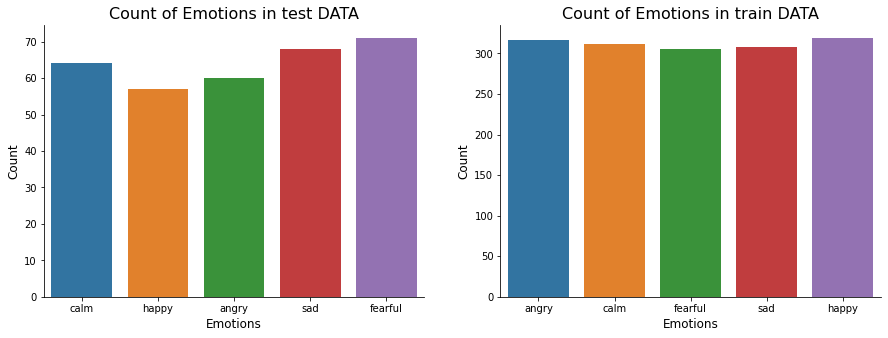

In [ ]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Count of Emotions in test DATA', size=16)
sns.countplot(x=test_dataframe.emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
# plt.show()

plt.subplot(1,2,2)
plt.title('Count of Emotions in train DATA', size=16)
sns.countplot(x=train_dataframe.emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Lets check if all the audios have only one channel of audio

In [ ]:
def check_channel(Dataframe):
  """
  this function will take a dataframe as input and loop throught it searching for multichannel audio, 
  if found it will print the shape as a Tensor and its index in the dataframe
  """
  for i,audio_file in enumerate(Dataframe["Audio_file"])
    data, rate = torchaudio.load(audio_file)
    data_shape = list(data.shape)

    if data_shape[0] != 1:
      print(f"index: {i}, shape : {data.shape}")

In [ ]:
check_channel(test_dataframe)

index: 102, shape : torch.Size([2, 166566])
index: 143, shape : torch.Size([2, 209809])


In [ ]:
check_channel(train_dataframe)

index: 644, shape : torch.Size([2, 203403])
index: 703, shape : torch.Size([2, 172972])


## Audio loader

Load the audio and return as a tensor. it will also turn multi-channel audio to mono.

In [ ]:
def load_mono(audio_path):
  wave, sr = librosa.load(audio_path,sr=None,mono=True)
  
  # trim silent edges
  wave, _ = librosa.effects.trim(wave)

  # convert to tensor
  wave = torch.FloatTensor(wave).unsqueeze(0)
  return wave, sr

## Data visualzation

### Spectroram

We can use Spectrogram for Imgae Classification.


In this notebook we will mainly focus on `Spectrogram`, `Mel Spectrogram` and `Mel-frequency cepstrum`.

In [ ]:
def show_audio(audio_path):
  y, sr = librosa.load(audio_path, sr=None,mono=True)
  print(f"Sample rate : {sr}")
  
  # trim silent edges
  audio, _ = librosa.effects.trim(y)
  
  fig = plt.figure(figsize=(20,15))
  n_fft = 2048
  hop_length = 256
  n_mels = 128

  plt.subplot(3,3,1)
  librosa.display.waveplot(audio, sr=sr);
  plt.title('1. raw wave form data');

  plt.subplot(3,3,2)
  D = np.abs(librosa.stft(audio[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
  plt.plot(D);
  plt.title(f'2. fourier transform of a window(length={n_fft})');

  plt.subplot(3,3,3)
  D = np.abs(librosa.stft(audio, n_fft=n_fft,  hop_length=hop_length))
  librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear');
  plt.colorbar();
  plt.title('3. applyed the Fourier Transform');

  plt.subplot(3,3,4)
  DB = librosa.amplitude_to_db(D, ref=np.max)
  librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
  plt.colorbar(format='%+2.0f dB');
  plt.title('4. Spectrogram');

  mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
  
  plt.subplot(3,3,5);
  librosa.display.specshow(mel, sr=sr, hop_length=hop_length, x_axis='linear');
  plt.ylabel('Mel filter');
  plt.colorbar();
  plt.title('5. Our filter bank for converting from Hz to mels.');

  plt.subplot(3, 3, 6);
  mel_10 = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=10)
  librosa.display.specshow(mel_10, sr=sr, hop_length=hop_length, x_axis='linear');
  plt.ylabel('Mel filter');
  plt.colorbar();
  plt.title('6. Easier to see what is happening with only 10 mels.');

  plt.subplot(3, 3, 7);
  idxs_to_plot = range(0,127,10)
  for i in idxs_to_plot:
      plt.plot(mel[i]);
  plt.legend(labels=[f'{i+1}' for i in idxs_to_plot]);
  plt.title('6. Plotting some of the triangular filters from the mels');

  plt.subplot(3,3,8)
  plt.plot(D[:, 1]);
  plt.plot(mel.dot(D[:, 1]));
  plt.legend(labels=['Hz', 'mel']);
  plt.title('8. One sampled window for example, before and after converting to mel.');

  plt.subplot(3,3,9)
  S = librosa.feature.melspectrogram(audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  S_DB = librosa.power_to_db(S, ref=np.max)
  librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
  plt.colorbar(format='%+2.0f dB');
  plt.title('9. Mel - Spectrogram');

  fig.tight_layout() 
  plt.show()

calm
Sample rate : 48000


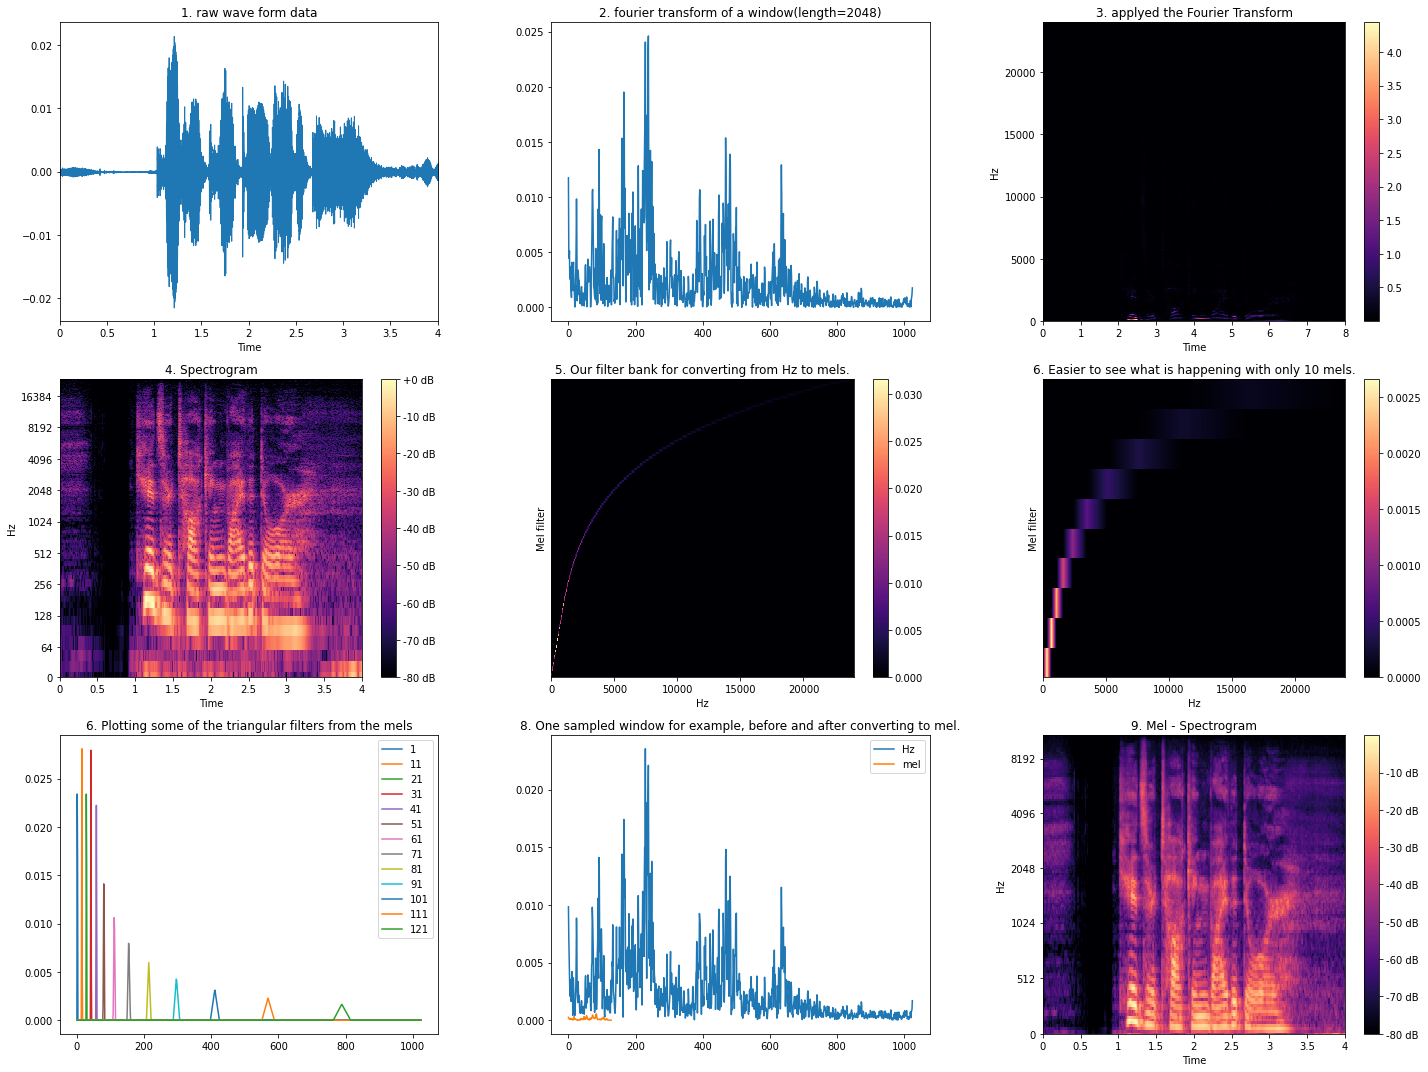

In [ ]:
path = test_dataframe.iloc[20]["Audio_file"]
print(test_dataframe.iloc[20]["emotion"])
show_audio(path)

# Lets play the audio
data, rate = load_mono(path)
ipd.Audio(data=data.numpy(),rate=rate)

angry
Sample rate : 48000


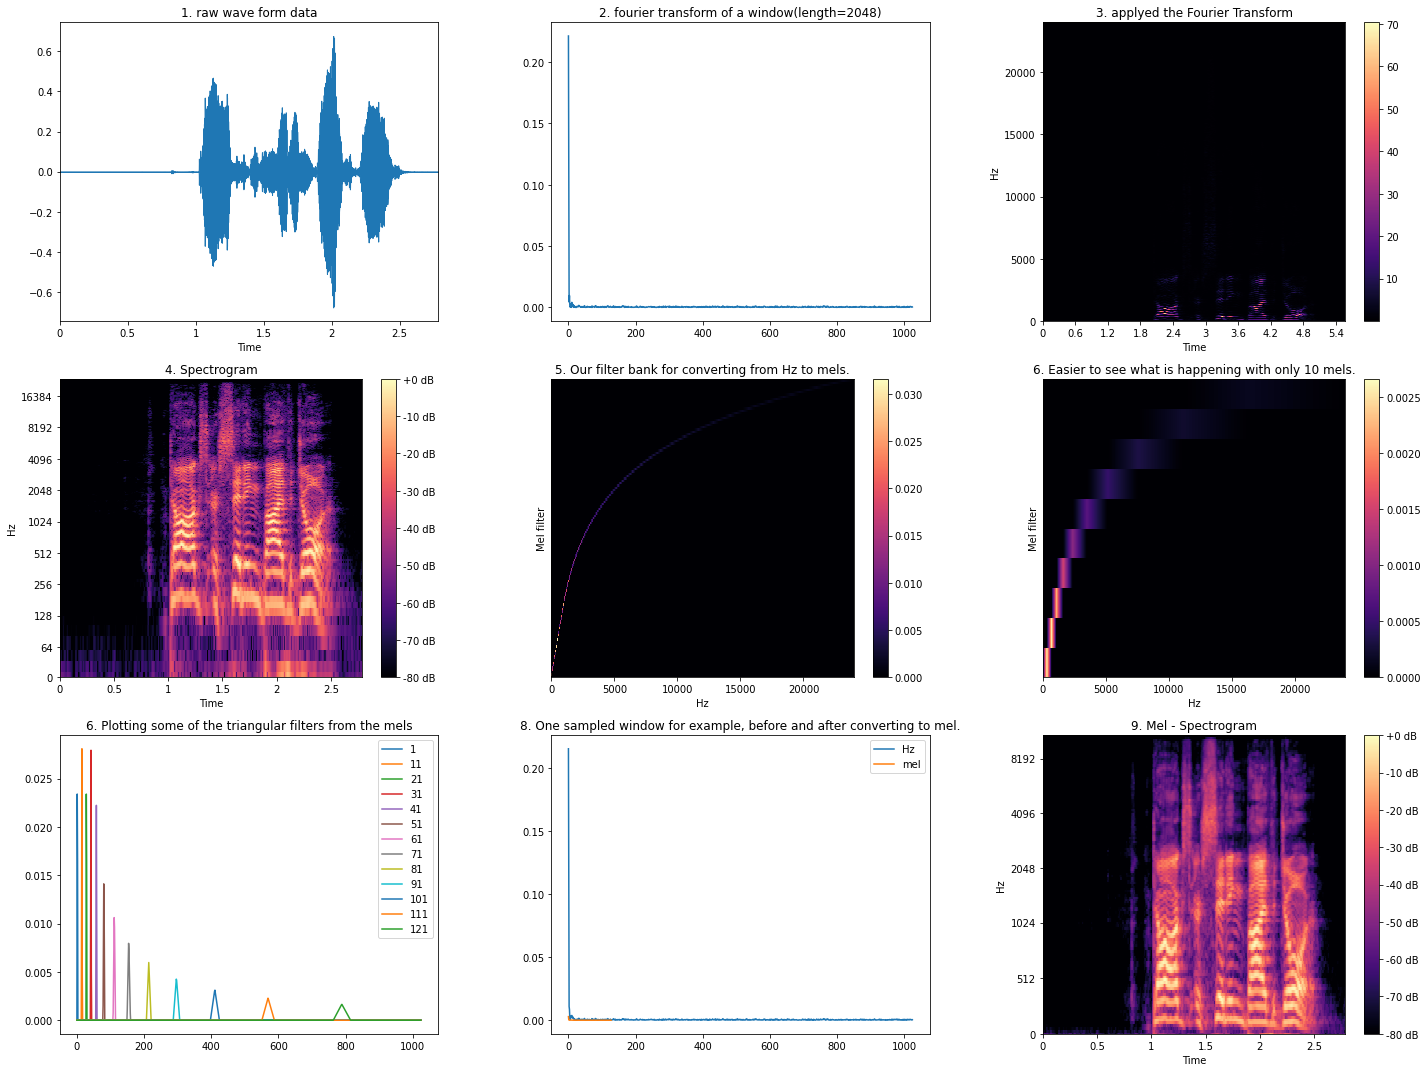

In [ ]:
i = 606
path = train_dataframe["Audio_file"].iloc[i]
print(train_dataframe.iloc[i]["emotion"])
show_audio(path)

# Lets play the audio 
data, rate = load_mono(path)
ipd.Audio(data=data.numpy(),rate=rate)

### classes

In [ ]:
emo_classes = list(set(train_dataframe["emotion"]))
len(emo_classes), emo_classes

(5, ['calm', 'sad', 'angry', 'happy', 'fearful'])

## Custom Audio Loader

Now lets modify our previous `load_mono` function to get the `Spectrogram`, `mel-sectrogram` or `mfcc`  as tensor at the same time with the `audio tensor` and `sample rate`

the function takes just the audio file path as input, then help of `librosa` it loads the audio into `numpy array` and generates the `basic spectrogram`(mode=0) `mel_spectrogram`(mode=1) or `mfcc`(mode=2) then these two are converted to tensors and returned with the `sample rate`.


In [ ]:
def load_spec(audio_path, mode=0):
  """
  takes audio path and mode to return various audio 2D representation with the 
  actual audio and sample rate as tensor

  use mode=1 to get melspectrogram
  and mode=2 to get mfcc
  Default mode=0 for Spectrogram
  """
  wave, sr = librosa.load(audio_path,sr=None,mono=True)
  # trim silent edges(below 60 db by default), change the threashold by passing `top_db`
  # The threshold (in decibels) below reference to consider as silence (default : 60 db)
  s, _ = librosa.effects.trim(wave,top_db=60)
  
  # convert to tensor
  wave = torch.FloatTensor(s).unsqueeze(0)
    
  # generate (mel)spectrogram / mfcc
  if(mode == 1):
    # s = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(wave)
    s = librosa.feature.melspectrogram(y=s, sr=sr, hop_length=512)
  elif(mode == 2):
    # s = torchaudio.transforms.MFCC(sample_rate=sr)(wave)
    s = librosa.feature.mfcc(y=s, sr=sr, n_mfcc=40)
  else:
    # s = torchaudio.transforms.Spectrogram()(wave)
    freqs, times, s = librosa.reassigned_spectrogram(y=s, sr=sr, hop_length=512)
    
  s = torch.FloatTensor(s).unsqueeze(0)
  return s, wave, sr

calm
torch.Size([1, 192192])
torch.Size([1, 1025, 376])


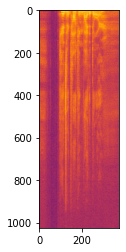

In [ ]:
i = 20
audio_path = test_dataframe["Audio_file"].iloc[i]

SPECTROGRAM, audio, rate = load_spec(audio_path,mode=0)
print(test_dataframe["emotion"].iloc[i])
print(audio.shape)
print(SPECTROGRAM.shape)

plt.imshow(SPECTROGRAM.log10()[0,:,:].numpy(), cmap="inferno")
ipd.Audio(data=audio,rate=rate)

calm
torch.Size([1, 192192])
torch.Size([1, 128, 376])


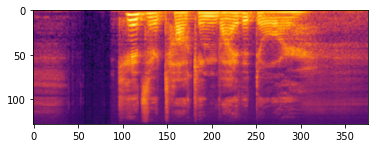

In [ ]:
audio_path = test_dataframe["Audio_file"].iloc[i]
mel_spec, audio, rate = load_spec(audio_path,mode=1)
print(test_dataframe["emotion"].iloc[i])
print(audio.shape)
print(mel_spec.shape)

plt.imshow(mel_spec.log10()[0,:,:].numpy(), cmap="inferno")
ipd.Audio(data=audio,rate=rate)

calm
torch.Size([1, 192192])
torch.Size([1, 40, 376])


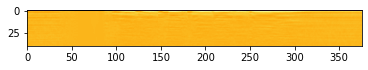

In [ ]:
audio_path = test_dataframe["Audio_file"].iloc[i]
MFCC, audio, rate = load_spec(audio_path,mode=2)
print(test_dataframe["emotion"].iloc[i])
print(audio.shape)
print(MFCC.shape)

plt.imshow(MFCC[0,:,:].numpy(), cmap="inferno")
ipd.Audio(data=audio,rate=rate)

Lets check if the `mel-spectrogram` tensors are of same `shape`

To do that we need to find max hight and width of the spectrogram for all the audios we have in the folders. 

Later it will be used to pad the `mel-spectrogram` tensors in the dataset.

The shape generated by `load_spec` will not be the same for all the audios passed to it for any `mode` so it need to be padded hence  the max_height and max_width calculation. 

In [ ]:
def get_maxDim(csv_file,max_height=0,max_width=0,mode =0, verbose=False):
  min_width = min_height = 5e5
    
  dataframe = pd.read_csv(csv_file)
  for i,path in enumerate(dataframe["Audio_file"]):

    spec,_,_ = load_spec(path,mode=mode)
    
    _, height, width = list(spec.shape) 
    if(height > max_height):
      max_height = height
      if verbose:
        print(f"{i} max height - {height}")
    if(width > max_width):
      max_width = width
      if verbose:
        print(f"{i} max width - {width}")
    

    if(min_width > width):
      min_width = width
      if verbose:
        print(f"{i} min width - {min_width}")
    if(min_height > height):
      min_height = height
      if verbose:
        print(f"{i} min height - {min_height}")


  print(f"min-width : {min_width},\tmin-height : {min_height}")
  print(f"max-width : {max_width},\tmax-height : {max_height}")

  return max_height,max_width

In [ ]:
# mode : 0-spectrogram, 1-mel_spectrogram, 2-mfcc

max_dim = get_maxDim(test_csv,mode=1)

max_dim = get_maxDim(train_csv, *max_dim, mode=1)


min-width : 123,	min-height : 128
max-width : 544,	max-height : 128
min-width : 128,	min-height : 128
max-width : 544,	max-height : 128


In [ ]:
max_dim

(128, 544)

## Data transforms (normalization & data augmentation)

Applying diffirent ***image*** transforms on the mel-spectrogram to randomly represent the same data to the model.

We could not achive full normalization on the data, so removed it.

**UPDATE : We tried to use image augmentation on the spectrogram of the images though it reduced overfitting in some cases but it turned out to be a failure as it prevented to gain more accuracy than 40%.**
So in the final version any data augmentation is not used.

In [ ]:
# Data transforms (normalization & data augmentation)
# stats = ((range of means for each channel), (range of std deviation for each channel))
# stats = ((-1.5), (2.51))
train_aug = tt.Compose([
                         tt.RandomCrop((max_dim[0],(max_dim[0]*125)//100), padding=12 ,pad_if_needed=True ,padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(0.4),
                         tt.RandomVerticalFlip(0.4),
                         tt.RandomRotation(22.5),
#                          tt.Normalize(*stats,inplace=True),
                        ])
# valid_tfms = tt.Compose([tt.Normalize(*stats)])

In [ ]:
# def denormalize(images, means, stds):
#     means = torch.tensor(means)
#     stds = torch.tensor(stds)
#     return images * stds + means
#     return images
# del denormalize

torch.Size([1, 133632])
mel-spec shape before:torch.Size([1, 128, 262])
mel-spec shape after :torch.Size([1, 128, 160])


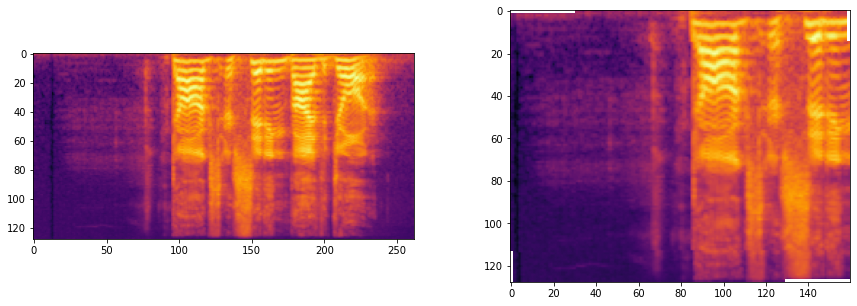

In [ ]:
audio_path = train_dataframe["Audio_file"].iloc[606]
mel_spec, audio, rate = load_spec(audio_path,mode=1)
print(audio.shape)
print(f"mel-spec shape before:{mel_spec.shape}")

# print(f"\n before : \n\tmax :{torch.max(mel_spec)},\n\tmin:{torch.min(mel_spec)},\n\tmean:{torch.mean(mel_spec)},\n\tstd:{torch.std(mel_spec)}\n")
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(mel_spec.log10()[0,:,:].numpy(),cmap="inferno")

mel_spec = train_aug(mel_spec)
print(f"mel-spec shape after :{mel_spec.shape}")
# print(f"\n after : \n\tmax :{torch.max(mel_spec)},\n\tmin:{torch.min(mel_spec)},\n\tmean:{torch.mean(mel_spec)},\n\tstd:{torch.std(mel_spec)}\n")
# mel_spec = denormalize(mel_spec, *stats)

plt.subplot(1,2,2)
plt.imshow(mel_spec.log10()[0,:,:].numpy(),cmap="inferno")


## DataSets

The `init` functions takes `csv_file` as path of the csv file, `data_dir` is the folder path the data is located, `dim` is the max dimention present in the data(spectrogram), `loader` is the function which can be used to do data augmentation and normalization, `mode` is the mode option to be used in the `load_spec` function.(mode=1 : mel-spectrogram in log10 scale, mode=2 : mfcc ,default : mode = 0) 

Another thing is loader is by default is none, in this case the spectograms will be all-side padded with Zeros to the max dim to make all the spectrogram tensor of same dimention.

If `loader` is passed the default padding wont take place instead the `loader` will take place of the default padding function, this loader functon need work with spectrograms(2d tensors).

In [ ]:
class ravdessEmoDataSet(Dataset):
  def __init__(self, csv_file, dim, loader=None, mode=0):
    self.dataframe = pd.read_csv(csv_file)
    self.classes = list(set(self.dataframe["emotion"]))
    # self.classes = list(set(self.dataframe["gender"]))
    self.loader = loader
    self.dim = dim
    self.mode = mode

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):
    row = self.dataframe.loc[index]
    audio_path,_,_, emotion, emo_intensity,_,_, gender = row
    
    label = self.classes.index(emotion)
    # label = self.classes.index(gender)

    s, waveform, rate = load_spec(audio_path,mode=self.mode)

    if self.loader:
      s = self.loader(s)
    else:
      _, height, width = list(s.shape)
      diff = [self.dim[0] - height, self.dim[1] - width]
      # pad on both side of the tensor by zeros
      pd1 = (diff[1]//2, diff[1]-diff[1]//2, diff[0]//2,diff[0]-diff[0]//2)
      s = F.pad(s, pd1, mode='constant', value=0)

    return s, label

In [ ]:
test_dataset = ravdessEmoDataSet(test_csv, dim = max_dim, mode=0)
# train_dataset = ravdessEmoDataSet(train_csv, data_dir, dim = max_dim, mode=0)
train_dataset = ravdessEmoDataSet(train_csv, dim = max_dim, mode=0, loader=train_aug)
len(test_dataset),len(train_dataset)

(320, 1560)

Again, below we can see the tensor after all cropping, reflection padding, random rotating being present in the train_dataset.

It is just a demonstration what would be passed to the model if image data augmentation is used on the spectrograms.

spectrogram shape torch.Size([1, 128, 160])
label : happy


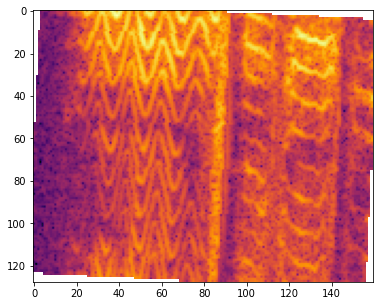

In [ ]:
x,l = train_dataset[129]
print(f"spectrogram shape {x.shape}")
print(f"label : {train_dataset.classes[l]}")
# x = denormalize(x, 0.28, 3.52)
plt.figure(figsize=(15,5))
plt.imshow(x.log10()[0,:,:].numpy(),cmap="inferno")

But the test dataset or the valudation dataset does not have all these data-auugmentation but all the mel-spectrogram is being padded with zeros to make the shape of all the images same.

spectrogram shape torch.Size([1, 128, 544])
label : happy


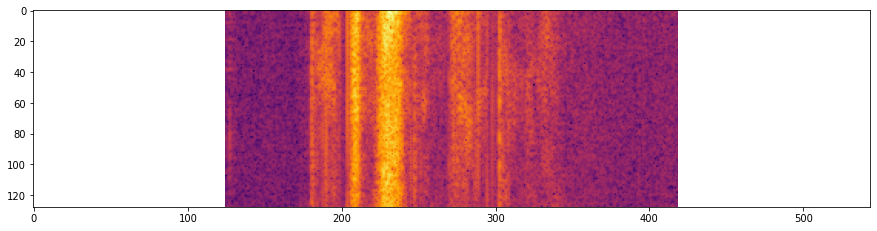

In [ ]:
x,l = test_dataset[3]
print(f"spectrogram shape {x.shape}")
print(f"label : {train_dataset.classes[l]}")
# x = denormalize(x, 0.28, 3.52)
plt.figure(figsize=(15,5))
plt.imshow(x.log10()[0,:,:].numpy(),cmap="inferno")

## DataLoader and Batch size

In [ ]:
batch_size = 40

train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

## Base class

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class SpectrogramClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

## The Model

### Using PreTrained model Resnet18

PreTrained turned out not so much useful for audio classification, as the model was not trained or intended to train on audio data.

But it is good enough to make decent prediction accuracy in Emotion Classification with audio only.

In [ ]:
class EmotionalResnet18(SpectrogramClassificationBase):
    def __init__(self, in_channels,num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = torchvision.models.resnet18(pretrained)
        
        # Replace the first layer
        self.network.conv1 = nn.Conv2d( 
            in_channels,
            self.network.conv1.out_channels,
            kernel_size=7,
            stride=2,
            padding=3
        )
        
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, 512)
        # new layer introduced
        self.fc2 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1),
        )
            

    def forward(self, xb):
        out = self.network(xb)
        return self.fc2(out)

In [ ]:
class_len= len(test_dataset.classes)
class_len

5

In [ ]:
model = EmotionalResnet18(1,class_len,pretrained=True)
model.parameters

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


<bound method Module.parameters of EmotionalResnet18(
  (network): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, mom

## Evaluate and fit

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
#         for batch in tqdm(train_loader):
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader),
                                                pct_start=0.20)

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
#         for batch in tqdm(train_loader):
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (torch.device('cpu')) or a GPU (torch.device('cuda'))

In [ ]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
model = to_device(model,device)

## Training The Model

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

We will be using the `fit_one_cycle` method to train the model, however we can do the training with constant `lr` by using the `fit` function

In [ ]:
# %%time
# history += fit(epochs,max_lr,model,train_dl,test_dl,opt_func=opt_func)

We're now ready to train our model. Instead of SGD (stochastic gradient descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. You can learn more about optimizers here: https://ruder.io/optimizing-gradient-descent/index.html

In [ ]:
epochs = 50
max_lr = 1e-5
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

### Training the model with ***Spectrogram***

In [ ]:
%%time
M = 0 # Spectrogram

spectro_max_dim = get_maxDim(test_csv,mode=M)
spectro_max_dim = get_maxDim(train_csv, *spectro_max_dim, mode=M)

test_dataset = ravdessEmoDataSet(test_csv, dim = spectro_max_dim, mode=M)
train_dataset = ravdessEmoDataSet(train_csv, dim = spectro_max_dim, mode=M)
print(f" length : \n\ttest:{len(test_dataset)},\n\ttrain:{len(train_dataset)}")

batch_size = 20

train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

class_len= len(test_dataset.classes)
print(f"class lenght : {class_len}")

spectro_model = EmotionalResnet18(1,class_len,pretrained=True)
# model.load_state_dict(torch.load("../input/emotional-speech-classification2d/EAC-spectro_model.pth"))

device = get_default_device()
print(f"device : {device}")

train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
spectro_model = to_device(spectro_model,device)

history = [evaluate(spectro_model, test_dl)]
print(history)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: divide by zero encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: divide by zero encountered in true_divide
  correction = np.real(S_th / S_h)


min-width : 123,	min-height : 1025
max-width : 544,	max-height : 1025
min-width : 128,	min-height : 1025
max-width : 544,	max-height : 1025
 length : 
	test:320,
	train:1560
class lenght : 5
device : cuda
[{'val_loss': 1.6140103340148926, 'val_acc': 0.16562500596046448}]
CPU times: user 1min 9s, sys: 3.3 s, total: 1min 13s
Wall time: 1min 23s


In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, spectro_model, train_dl, test_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [0],last_lr: 6.295751319816769e-07, train_loss: 1.6112, val_loss: 1.6097, val_acc: 0.1719


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [1],last_lr: 1.3076361188051793e-06, train_loss: 1.6096, val_loss: 1.6070, val_acc: 0.1969


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [2],last_lr: 2.367679552536707e-06, train_loss: 1.6047, val_loss: 1.6010, val_acc: 0.3313


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [3],last_lr: 3.7056766226629795e-06, train_loss: 1.5950, val_loss: 1.5868, val_acc: 0.3187


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [4],last_lr: 5.1903211588457505e-06, train_loss: 1.5732, val_loss: 1.5521, val_acc: 0.3438


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [5],last_lr: 6.675915541327631e-06, train_loss: 1.5315, val_loss: 1.5119, val_acc: 0.3625


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [6],last_lr: 8.016668935887062e-06, train_loss: 1.4954, val_loss: 1.4823, val_acc: 0.3688


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [7],last_lr: 9.081004676522089e-06, train_loss: 1.4675, val_loss: 1.4546, val_acc: 0.4375


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [8],last_lr: 9.764472721317657e-06, train_loss: 1.4284, val_loss: 1.4221, val_acc: 0.4844


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [9],last_lr: 1e-05, train_loss: 1.3976, val_loss: 1.3996, val_acc: 0.5094


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [10],last_lr: 9.984586730318967e-06, train_loss: 1.3689, val_loss: 1.3779, val_acc: 0.5531


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [11],last_lr: 9.938441949208878e-06, train_loss: 1.3368, val_loss: 1.3606, val_acc: 0.5750


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [12],last_lr: 9.861850154589975e-06, train_loss: 1.3158, val_loss: 1.3434, val_acc: 0.5906


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [13],last_lr: 9.755283560345444e-06, train_loss: 1.2874, val_loss: 1.3395, val_acc: 0.5813


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [14],last_lr: 9.619399184965784e-06, train_loss: 1.2537, val_loss: 1.3104, val_acc: 0.6156


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [15],last_lr: 9.455034800811355e-06, train_loss: 1.2098, val_loss: 1.2886, val_acc: 0.6688


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [16],last_lr: 9.263203768967175e-06, train_loss: 1.1836, val_loss: 1.2561, val_acc: 0.7000


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [17],last_lr: 9.04508879153485e-06, train_loss: 1.1536, val_loss: 1.2369, val_acc: 0.6844


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [18],last_lr: 8.802034619880843e-06, train_loss: 1.1286, val_loss: 1.2343, val_acc: 0.7000


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [19],last_lr: 8.535539763797115e-06, train_loss: 1.1003, val_loss: 1.2122, val_acc: 0.7531


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [20],last_lr: 8.247247252689952e-06, train_loss: 1.0777, val_loss: 1.2181, val_acc: 0.7094


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [21],last_lr: 7.93893450575732e-06, train_loss: 1.0517, val_loss: 1.2035, val_acc: 0.7562


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-

Epoch [22],last_lr: 7.612502373608451e-06, train_loss: 1.0473, val_loss: 1.1971, val_acc: 0.7500


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [23],last_lr: 7.2699634188877404e-06, train_loss: 1.0290, val_loss: 1.1886, val_acc: 0.7375


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [24],last_lr: 6.913429508156803e-06, train_loss: 1.0189, val_loss: 1.1934, val_acc: 0.7500


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [25],last_lr: 6.545098791534851e-06, train_loss: 1.0047, val_loss: 1.1900, val_acc: 0.7562


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [26],last_lr: 6.167242150372251e-06, train_loss: 0.9943, val_loss: 1.1896, val_acc: 0.7625


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: divide by zero encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: divide by zero encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist

Epoch [27],last_lr: 5.782189196511855e-06, train_loss: 0.9861, val_loss: 1.1752, val_acc: 0.7781


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [28],last_lr: 5.392313909457312e-06, train_loss: 0.9773, val_loss: 1.1729, val_acc: 0.7563


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [29],last_lr: 5.000020000000001e-06, train_loss: 0.9746, val_loss: 1.1723, val_acc: 0.7594


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [30],last_lr: 4.607726090542691e-06, train_loss: 0.9621, val_loss: 1.1824, val_acc: 0.7469


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [31],last_lr: 4.217850803488146e-06, train_loss: 0.9709, val_loss: 1.1804, val_acc: 0.7656


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [32],last_lr: 3.832797849627752e-06, train_loss: 0.9628, val_loss: 1.1729, val_acc: 0.7687


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [33],last_lr: 3.4549412084651512e-06, train_loss: 0.9606, val_loss: 1.1756, val_acc: 0.7594


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [34],last_lr: 3.086610491843199e-06, train_loss: 0.9518, val_loss: 1.1648, val_acc: 0.7687


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [35],last_lr: 2.730076581112261e-06, train_loss: 0.9556, val_loss: 1.1670, val_acc: 0.7656


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [36],last_lr: 2.3875376263915506e-06, train_loss: 0.9499, val_loss: 1.1683, val_acc: 0.7656


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [37],last_lr: 2.0611054942426807e-06, train_loss: 0.9510, val_loss: 1.1652, val_acc: 0.7687


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [38],last_lr: 1.7527927473100492e-06, train_loss: 0.9517, val_loss: 1.1671, val_acc: 0.7687


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [39],last_lr: 1.4645002362028868e-06, train_loss: 0.9515, val_loss: 1.1685, val_acc: 0.7656


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [40],last_lr: 1.1980053801191575e-06, train_loss: 0.9436, val_loss: 1.1659, val_acc: 0.7719


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [41],last_lr: 9.54951208465151e-07, train_loss: 0.9483, val_loss: 1.1708, val_acc: 0.7594


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [42],last_lr: 7.368362310328264e-07, train_loss: 0.9459, val_loss: 1.1653, val_acc: 0.7688


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [43],last_lr: 5.450051991886449e-07, train_loss: 0.9448, val_loss: 1.1615, val_acc: 0.7625


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [44],last_lr: 3.806408150342166e-07, train_loss: 0.9428, val_loss: 1.1636, val_acc: 0.7719


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [45],last_lr: 2.447564396545583e-07, train_loss: 0.9452, val_loss: 1.1660, val_acc: 0.7688


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: divide by zero encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: divide by zero encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist

Epoch [46],last_lr: 1.3818984541002519e-07, train_loss: 0.9434, val_loss: 1.1671, val_acc: 0.7625


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [47],last_lr: 6.159805079112361e-08, train_loss: 0.9433, val_loss: 1.1625, val_acc: 0.7625


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [48],last_lr: 1.5453269681034844e-08, train_loss: 0.9425, val_loss: 1.1644, val_acc: 0.7781


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-p

Epoch [49],last_lr: 4.0000000000000004e-11, train_loss: 0.9485, val_loss: 1.1675, val_acc: 0.7656
CPU times: user 11min 44s, sys: 8min 47s, total: 20min 31s
Wall time: 1h 1min 31s


In [ ]:
train_time0 = "~1h"

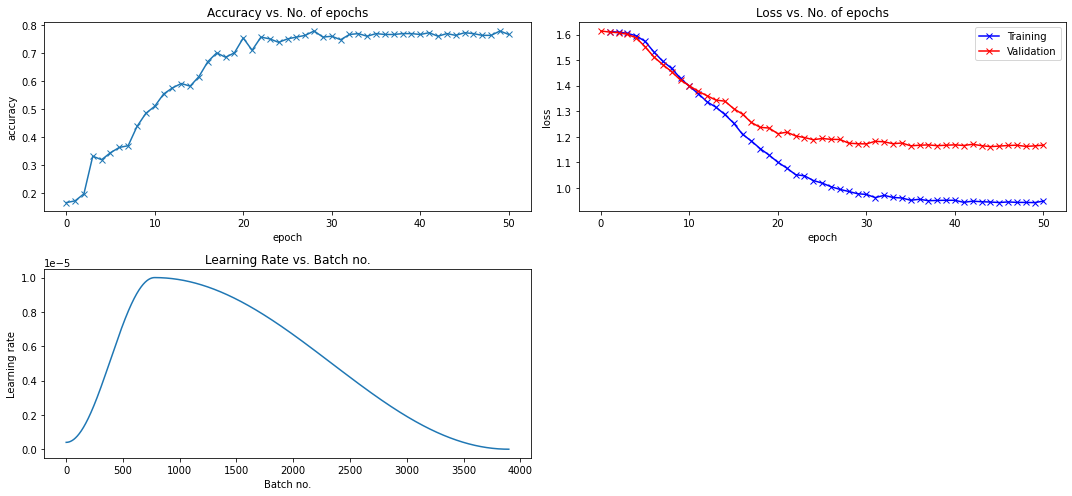

In [ ]:
fig = plt.figure(figsize=(15,7))

plt.subplot(2,2,1)
plot_accuracies(history)

plt.subplot(2,2,2)
plot_losses(history)

plt.subplot(2,2,3)
plot_lrs(history)

fig.tight_layout()
plt.show()

In [ ]:
torch.save(spectro_model.state_dict(), 'EAC-spectro_model.pth')
# jovian.commit(project=project_name, outputs=['EAC-spectro_model.pth'],files=[test_csv,train_csv], environment=None)

### Training the model with Mel-Spectrogram

In [ ]:
%%time

M = 1 # mel-spectrogram

mel_max_dim = get_maxDim(test_csv,mode=M)
mel_max_dim = get_maxDim(train_csv, *mel_max_dim, mode=M)

test_dataset = ravdessEmoDataSet(test_csv, dim = mel_max_dim, mode=M)
train_dataset = ravdessEmoDataSet(train_csv, dim = mel_max_dim, mode=M)
print(f" length : \n\ttest:{len(test_dataset)},\n\ttrain:{len(train_dataset)}")

batch_size = 80

train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

class_len= len(test_dataset.classes)
print(f"class lenght : {class_len}")

melSpectro_model = EmotionalResnet18(1,class_len,pretrained=True)
# model.load_state_dict(torch.load("./EAC-melSpectro_model.pth"))

device = get_default_device()
print(f"device : {device}")

train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
melSpectro_model = to_device(melSpectro_model,device)


history = [evaluate(melSpectro_model, test_dl)]
print(history)

min-width : 123,	min-height : 128
max-width : 544,	max-height : 128
min-width : 128,	min-height : 128
max-width : 544,	max-height : 128
 length : 
	test:320,
	train:1560
class lenght : 5
device : cuda
[{'val_loss': 1.5955703258514404, 'val_acc': 0.34062498807907104}]
CPU times: user 47.5 s, sys: 37.3 s, total: 1min 24s
Wall time: 51 s


In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, melSpectro_model, train_dl, test_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0],last_lr: 6.143154327270654e-07, train_loss: 1.6026, val_loss: 1.6045, val_acc: 0.1813
Epoch [1],last_lr: 1.2813965372108838e-06, train_loss: 1.6000, val_loss: 1.6010, val_acc: 0.1813
Epoch [2],last_lr: 2.3358904562134905e-06, train_loss: 1.5941, val_loss: 1.5955, val_acc: 0.1813
Epoch [3],last_lr: 3.6735446260516567e-06, train_loss: 1.5875, val_loss: 1.5860, val_acc: 0.2250
Epoch [4],last_lr: 5.1621118388333754e-06, train_loss: 1.5773, val_loss: 1.5751, val_acc: 0.3469
Epoch [5],last_lr: 6.65442486547299e-06, train_loss: 1.5643, val_loss: 1.5657, val_acc: 0.3313
Epoch [6],last_lr: 8.002946146918271e-06, train_loss: 1.5532, val_loss: 1.5568, val_acc: 0.3281
Epoch [7],last_lr: 9.07435409805753e-06, train_loss: 1.5431, val_loss: 1.5454, val_acc: 0.3344
Epoch [8],last_lr: 9.762723949061357e-06, train_loss: 1.5255, val_loss: 1.5304, val_acc: 0.3375
Epoch [9],last_lr: 1e-05, train_loss: 1.5089, val_loss: 1.5116, val_acc: 0.3719
Epoch [10],last_lr: 9.984586730318967e-06, train_loss:

In [ ]:
train_time1 = "~45min"

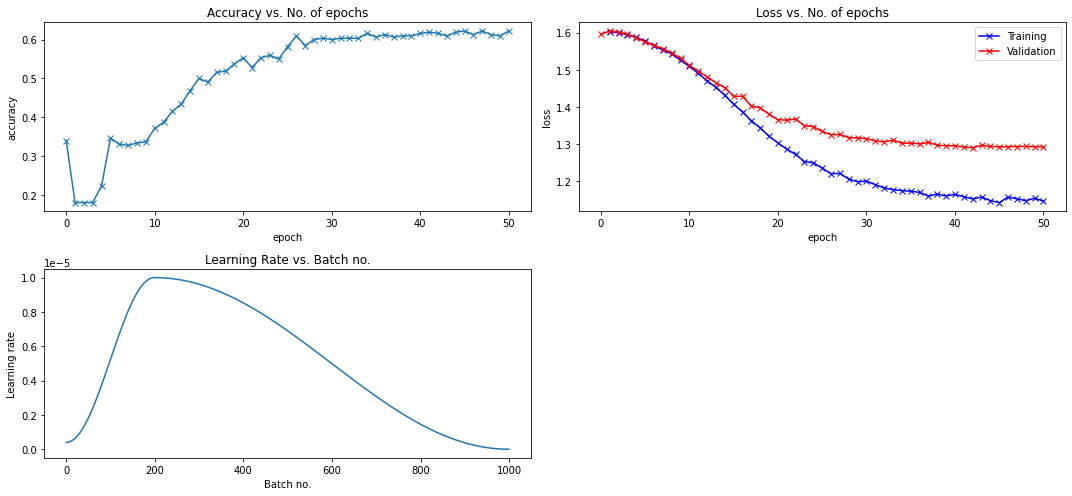

In [ ]:
fig = plt.figure(figsize=(15,7))

plt.subplot(2,2,1)
plot_accuracies(history)

plt.subplot(2,2,2)
plot_losses(history)

plt.subplot(2,2,3)
plot_lrs(history)

fig.tight_layout() 
plt.show()

In [ ]:
torch.save(melSpectro_model.state_dict(), 'EAC-melSpectro_model.pth')
# jovian.commit(project=project_name, outputs=['EAC-melSpectro_model.pth'],files=[test_csv,train_csv], environment=None)

### training the model on mfcc

In [ ]:
%%time
M = 2 # mfcc

mfcc_max_dim = get_maxDim(test_csv,mode=M)
mfcc_max_dim = get_maxDim(train_csv, *mfcc_max_dim, mode=M)

test_dataset = ravdessEmoDataSet(test_csv, dim = mfcc_max_dim, mode=M)
train_dataset = ravdessEmoDataSet(train_csv, dim = mfcc_max_dim, mode=M)
# train_dataset = ravdessEmoDataSet(train_csv, dim = max_dim, mode=0, loader=train_aug)
print(f" length : \n\ttest:{len(test_dataset)},\n\ttrain:{len(train_dataset)}")

batch_size = 80

train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

class_len= len(test_dataset.classes)
print(f"class lenght : {class_len}")

mfcc_model = EmotionalResnet18(1,class_len,pretrained=False)
# model.load_state_dict(torch.load("./EAC-mfcc_model.pth"))

device = get_default_device()
print(f"device : {device}")

train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
mfcc_model = to_device(mfcc_model,device)


history = [evaluate(mfcc_model, test_dl)]
history

min-width : 123,	min-height : 40
max-width : 544,	max-height : 40
min-width : 128,	min-height : 40
max-width : 544,	max-height : 40
 length : 
	test:320,
	train:1560
class lenght : 5
device : cuda
CPU times: user 51.4 s, sys: 40.9 s, total: 1min 32s
Wall time: 56 s


In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, mfcc_model, train_dl, test_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0],last_lr: 6.143154327270654e-07, train_loss: 1.6117, val_loss: 1.6047, val_acc: 0.2250
Epoch [1],last_lr: 1.2813965372108838e-06, train_loss: 1.6061, val_loss: 1.6025, val_acc: 0.2250
Epoch [2],last_lr: 2.3358904562134905e-06, train_loss: 1.6043, val_loss: 1.5940, val_acc: 0.2719
Epoch [3],last_lr: 3.6735446260516567e-06, train_loss: 1.5909, val_loss: 1.5798, val_acc: 0.3125
Epoch [4],last_lr: 5.1621118388333754e-06, train_loss: 1.5718, val_loss: 1.5607, val_acc: 0.3187
Epoch [5],last_lr: 6.65442486547299e-06, train_loss: 1.5477, val_loss: 1.5433, val_acc: 0.3313
Epoch [6],last_lr: 8.002946146918271e-06, train_loss: 1.5276, val_loss: 1.5247, val_acc: 0.3500
Epoch [7],last_lr: 9.07435409805753e-06, train_loss: 1.5090, val_loss: 1.5081, val_acc: 0.3625
Epoch [8],last_lr: 9.762723949061357e-06, train_loss: 1.4954, val_loss: 1.4981, val_acc: 0.3781
Epoch [9],last_lr: 1e-05, train_loss: 1.4849, val_loss: 1.4894, val_acc: 0.3844
Epoch [10],last_lr: 9.984586730318967e-06, train_loss:

In [ ]:
train_time2 = "~25 mins"

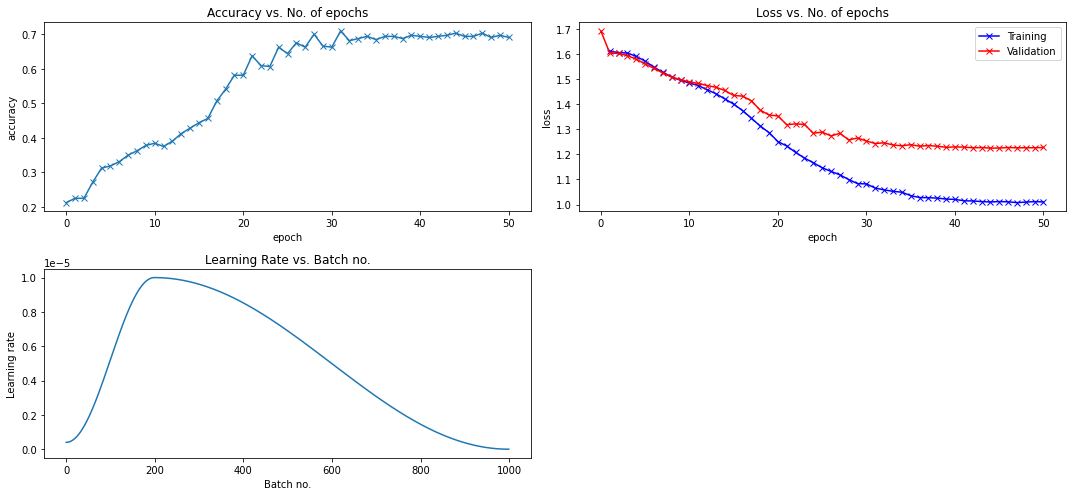

In [ ]:
fig = plt.figure(figsize=(15,7))

plt.subplot(2,2,1)
plot_accuracies(history)

plt.subplot(2,2,2)
plot_losses(history)

plt.subplot(2,2,3)
plot_lrs(history)

fig.tight_layout() 
plt.show()

In [ ]:
torch.save(mfcc_model.state_dict(), 'EAC-mfcc_model.pth')
# jovian.commit(project=project_name, outputs=['EAC-mfcc_model.pth'],files=[test_csv,train_csv], environment=None)

In [ ]:
!cp "/content/EAC-melSpectro_model.pth" -r "/content/drive/MyDrive"

In [ ]:
!cp "/content/EAC-mfcc_model.pth" -r "/content/drive/MyDrive"

In [ ]:
!cp "/content/EAC-spectro_model.pth" -r "/content/drive/MyDrive"

## Summary : Choosing the MODE

**Spectrogram-dataset**

- In accuracy spectrogarm-model was ahead of the others by more than 3-5% in case of using pretrained model
- But it required the most RAM, TIME, computation to achieve it, 
- yet some degree of over fitting was noticeable after 20-25 epochs.

HISTORY(last three): 

1. epochs: 50,accuracy : 0.7563, time : 1h 45min 55s, pretrained: True
2. epochs : 50, accuracy: 0.2281 time : 1h 50min 39s,  pretrained: False
3. epochs: 30, accuracy : 0.7094, time : 1h 3min 39s,  pretrained: True

**Mel_Spectrogram-dataset**

- In accuracy it was neck and neck with `mfcc-dataset` ahead by only 1%,
- Though it had taken more time than `mfcc-dataset` but a lot less than `spetrogram-dataset`
- On the UP side working with this dataset showed the least overfitting among the three 

HISTORY(last three):
1. ecochs : 50, accuracy : 0.6687, time : 37min 10s, pretrained : True
2. ecochs : 50, accuracy : 0.3844, time : 35min 1s, pretrained : False
3. epochs : 30, accuracy : 0.6344, time : 21min 25s, pretrained : True

**MFCC-dataset**

- In time-consumption it is the lowest with a cost of bit accuracy
- most of all it didn't need use the pretrained wights to get to over 65% accuracy
- It has also shown the most ammount of overfitting after 25 epoch

HISTORY(last three):
1. epochs: 50, accuracy : 0.6594, time : 22min 43s, pretrained : True
2. epochs: 50, accuracy : 0.6719, time : 22min 56s, pretrained : False
3. epochs: 30, acccurcy : 0.5688, time : 13min 14s, pretrained : False

Our expectation was the dataset with the mel-spectrogram will be the best in all categories.


## Testing Individual Audio

Tring to predict with the `mode` set to "0" for audio as Spectrogram with the model trained for 30 epochs with pretrained set to `True`

In [ ]:
device

device(type='cuda')

In [ ]:
spectro_max_dim, mel_max_dim, mfcc_max_dim

((1025, 544), (128, 544), (40, 544))

In [ ]:
test_dataset = ravdessEmoDataSet(test_csv, dim = spectro_max_dim, mode=0)
test_dl = DataLoader(test_dataset, 20, num_workers=4, pin_memory=True)

class_len= len(test_dataset.classes)
# model = EmotionalResnet18(1,class_len,pretrained=False)
# model.load_state_dict(torch.load("./EAC-spectro_model.pth"))
# model.load_state_dict(torch.load("../input/emotional-speech-classification2d/EAC-spectro_model.pth"))

test_dl = DeviceDataLoader(test_dl, device)
model = to_device(spectro_model, device)

evaluate(model, test_dl)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: divide by zero encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/usr/local/lib/python3.7/dist

{'val_acc': 0.7656249403953552, 'val_loss': 1.1675105094909668}

In [ ]:
def predict_emotion(audio_path, model, max_height=0, max_width=0, mode=0):
    s, waveform, rate = load_spec(audio_path, mode = mode)

    _, height, width = list(s.shape)
    
    diff = [(max_height - height), (max_width - width)]
    # pad on both side of the tensor by zeros
    pd1 = (diff[1]//2, diff[1]-diff[1]//2, diff[0]//2,diff[0]-diff[0]//2)
    s = F.pad(s, pd1, mode='constant', value=0)
    
    # Convert to a batch of 1
    xb = to_device(s.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    print(f"predicted : {train_dataset.classes[preds[0].item()]}")
    return waveform,rate
    # return preds[0].item()

In [ ]:
from random import randrange

In [ ]:
len(test_dataframe)

320

In [ ]:
# indx = 15
indx = randrange(len(test_dataframe))

audio_path = os.path.join(test_dataframe.iloc[indx]["Audio_file"])

print(f"Audio Location : {audio_path}")
print(f"Label : {test_dataframe.iloc[indx]['emotion']}")

wave = predict_emotion(audio_path,model, *spectro_max_dim)

# ipd.Audio(data=wave,rate=48000)

Audio Location : ravdess-emotional-song-audio/Actor_21/03-02-04-02-01-01-21.wav
Label : sad
predicted : sad


In [ ]:
# indx = 150
indx = randrange(len(test_dataframe))
audio_path = os.path.join(test_dataframe.iloc[indx]["Audio_file"])

print(f"Audio Location : {audio_path}")
print(f"Label : {test_dataframe.iloc[indx]['emotion']}")

wave = predict_emotion(audio_path,model, *spectro_max_dim)

# ipd.Audio(data=wave,rate=48000)

Audio Location : ravdess-emotional-song-audio/Actor_04/03-02-06-01-02-01-04.wav
Label : fearful
predicted : fearful


In [ ]:
# indx = 199
indx = randrange(len(test_dataframe))
audio_path = os.path.join(test_dataframe.iloc[indx]["Audio_file"])

print(f"Audio Location : {audio_path}")
print(f"Label : {test_dataframe.iloc[indx]['emotion']}")

wave = predict_emotion(audio_path,model, *spectro_max_dim)

# ipd.Audio(data=wave,rate=48000)

Audio Location : ravdess-emotional-speech-audio/Actor_19/03-01-02-01-01-02-19.wav
Label : calm
predicted : sad


In [ ]:
# indx = 315
indx = randrange(len(test_dataframe))
audio_path = os.path.join(test_dataframe.iloc[indx]["Audio_file"])

print(f"Audio Location : {audio_path}")
print(f"Label : {test_dataframe.iloc[indx]['emotion']}")

wave = predict_emotion(audio_path,model, *spectro_max_dim)

# ipd.Audio(data=wave,rate=48000)

Audio Location : ravdess-emotional-speech-audio/Actor_02/03-01-03-02-01-02-02.wav
Label : happy
predicted : happy
